In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [26]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
exp_base = {3: "20180509_18_36_23_dcnn_f3_150KE_lr2e02",
            2: "20180509_18_36_28_dcnn_f2_150KE_lr2e02",
            1: "20180509_18_36_32_dcnn_f1_150KE_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])


exp_mc005_brier = {3: "20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02",
                   2: "20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02",
                   1: "20180426_14_45_50_dcnn_mc_f1p005_brier_150KE_lr2e02",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])


# 20180508_11_47_05_dcnn_mc_f2p01_brier_20KE_lr2e02
# 20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02
exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])



## Load experimental data and test data set

In [27]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_base = ExperimentHandler.load_experiment(exp_base_path)
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("Base DCNN fold-{} (p={})".format(
                                     exper_hdl_base.exper.run_args.fold_ids[0],
                                     exper_hdl_base.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_base.exper.model_name))


exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 0
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_39_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
Model name Base DCNN fold-0 (p=0.5)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_36_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


  0%|          | 0/25 [00:00<?, ?it/s]

Model name MC-dropout-brier fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout brier fold-0 (p=0.1)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:02<00:00, 12.13it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Evaluate models with referral

In [114]:

exper_handler = exper_hdl_mc01_brier
ref_handler = ReferralHandler(exper_handler, test_set=test_set, referral_thresholds=[0.14, 0.15],
                              verbose=False, do_save=True, num_of_images=None, pos_only=True)
ref_handler.test(non_referral=True, verbose=False)


INFO - Running evaluation with referral for threshold 0_14
Overall result wo referral -  dice(RV/Myo/LV):	ES 0.87/0.89/0.92	ED 0.94/0.88/0.96
Overall result referral -  dice(RV/Myo/LV):	ES 0.91/0.92/0.94	ED 0.95/0.90/0.97
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/ref_test_results_25imgs_fold0_utr0_14_pos_only
INFO - Running evaluation with referral for threshold 0_15
Overall result wo referral -  dice(RV/Myo/LV):	ES 0.87/0.89/0.92	ED 0.94/0.88/0.96
Overall result referral -  dice(RV/Myo/LV):	ES 0.90/0.92/0.94	ED 0.95/0.89/0.97
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/ref_test_results_25imgs_fold0_utr0_15_pos_only
INFO - Done


In [141]:
from utils.referral_handler import ReferralResults

exper_dict = exp_mc01_brier
referral_thresholds = [0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24]
ref_results_pos_only = ReferralResults(exper_dict, referral_thresholds, pos_only=True, print_results=False)
ref_results = ReferralResults(exper_dict, referral_thresholds, pos_only=False, print_results=False)

INFO - Loading referral results for thresholds [0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24]
WARNING - referral positives-only=True
INFO - Loading referral results for thresholds [0.14, 0.15, 0.16, 0.18, 0.2, 0.22, 0.24]
WARNING - referral positives-only=False


### Print referral results per referral threshold

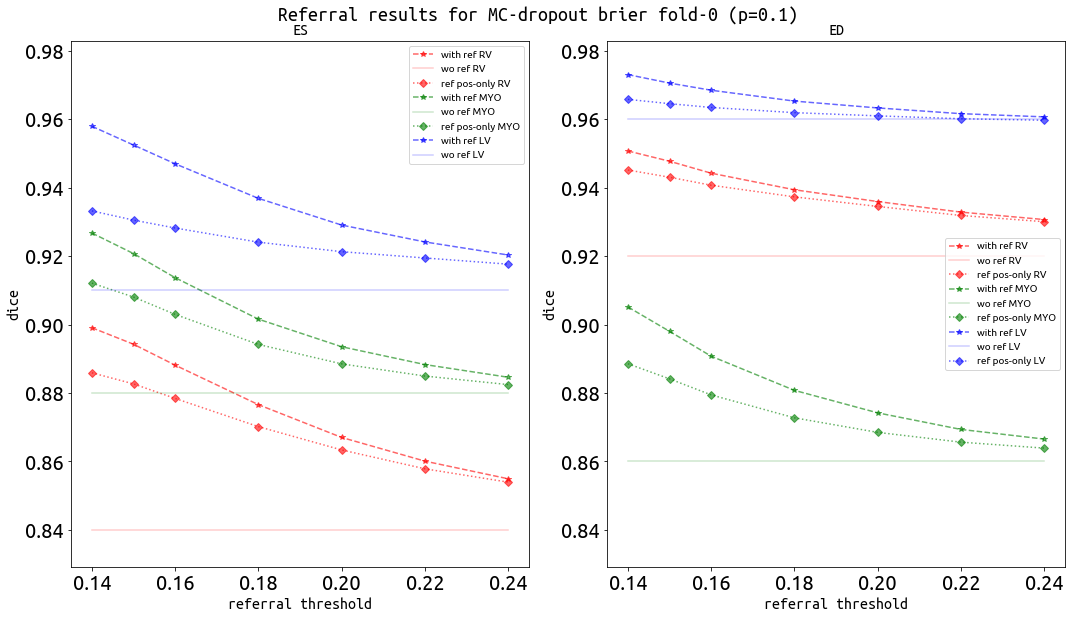

In [182]:

model_name = exper_handler.exper.model_name
plot_referral_results(ref_results.dice, model_name,
                      ref_results_pos_only.dice, width=16 , height=9, do_save=False)

## Run model evaluation of test set

In [ ]:
mc_samples = 10
sample_weights = True
store_details = False
image_range =  None # [0, 9, 22] #  [24]

generate_stats = False

save_results = True
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_pred_labels = True

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)


    
print("Ready")

In [ ]:
from utils.test_results import load_all_results
# Dictionaries with experiment folder per fold-id
# exp_mc005_brier
# exp_mc01_brier
# exp_base
res_dice, res_hd = load_all_results(exp_mc01_brier, search_prefix="test_results_25imgs_mc*")


In [ ]:
exper_handler.create_filtered_umaps(u_threshold=0.14)

## Run evaluation of MC model with referral

In [7]:
mc_samples = 10
sample_weights = True
store_details = True
image_range = [0] # [9] # [10, 24] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = True
save_pred_labels = False

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=True, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)



print("Ready")

Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
	 Segmentation errors - 	ES 0.0/40.0/18.0		ED 0.0/314.0/101.0
	 Segmentation errors - 	ES 120.0/699.0/288.0		ED 526.0/714.0/310.0
	 Segmentation errors - 	ES 1476.0/671.0/220.0		ED 889.0/819.0/372.0
	 Segmentation errors - 	ES 459.0/528.0/225.0		ED 543.0/401.0/120.0
	 Segmentation errors - 	ES 448.0/333.0/128.0		ED 304.0/422.0/131.0
	 Segmentation errors - 	ES 285.0/298.0/107.0		ED 296.0/348.0/125.0
	 Segmentation errors - 	ES 287.0/288.0/119.0		ED 302.0/397.0/125.0
	 Segmentation errors - 	ES 194.0/293.0/170.0		ED 241.0/270.0/107.0
	 Segmentation errors - 	ES 218.0/313.0/117.0		ED 258.0/314.0/100.0
	 Segmentation errors - 	ES 194.0/227.0/69.0		ED 263.0/236.0/98.0
	 Segmentation errors - 	ES 224.0/238.0/55.0		ED 223

## Run evaluation for baseline DCNN model

In [ ]:
mc_samples = 1
sample_weights = False
store_details = False
image_range =  None # [0, 9, 22] #  [24]

generate_stats = False

save_results = True
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_pred_labels = True

exper_handler = exper_hdl_base

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)


    
print("Ready")

In [ ]:
exper_hdl_mc01_brier.create_filtered_umaps(u_threshold=0.12, verbose=True, patient_id="patient006")
print("Ready")

In [ ]:
exper_handler = exper_hdl_mc005_brier

# image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=True, do_show=True, u_type=u_type,
               use_saved_umaps=True)

# Compare performance of models

In [ ]:
image_range = [24]

for img_idx in image_range:
    exper_handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="probs",
                                                     do_save=True, do_show=False,
                                                     model_name=exper_handler.exper.model_name)

In [ ]:
exper_handler.test_results.generate_all_statistics()
u_values_slices = exper_handler.test_results.image_probs_categorized[0]
for slice_id in range(len(u_values_slices)):
    u_values_slice = u_values_slices[slice_id]
    print(len(u_values_slice["es_err_std"][1]), len(u_values_slice["es_cor_std"][1]))

Rows/columns/height 22/4/86


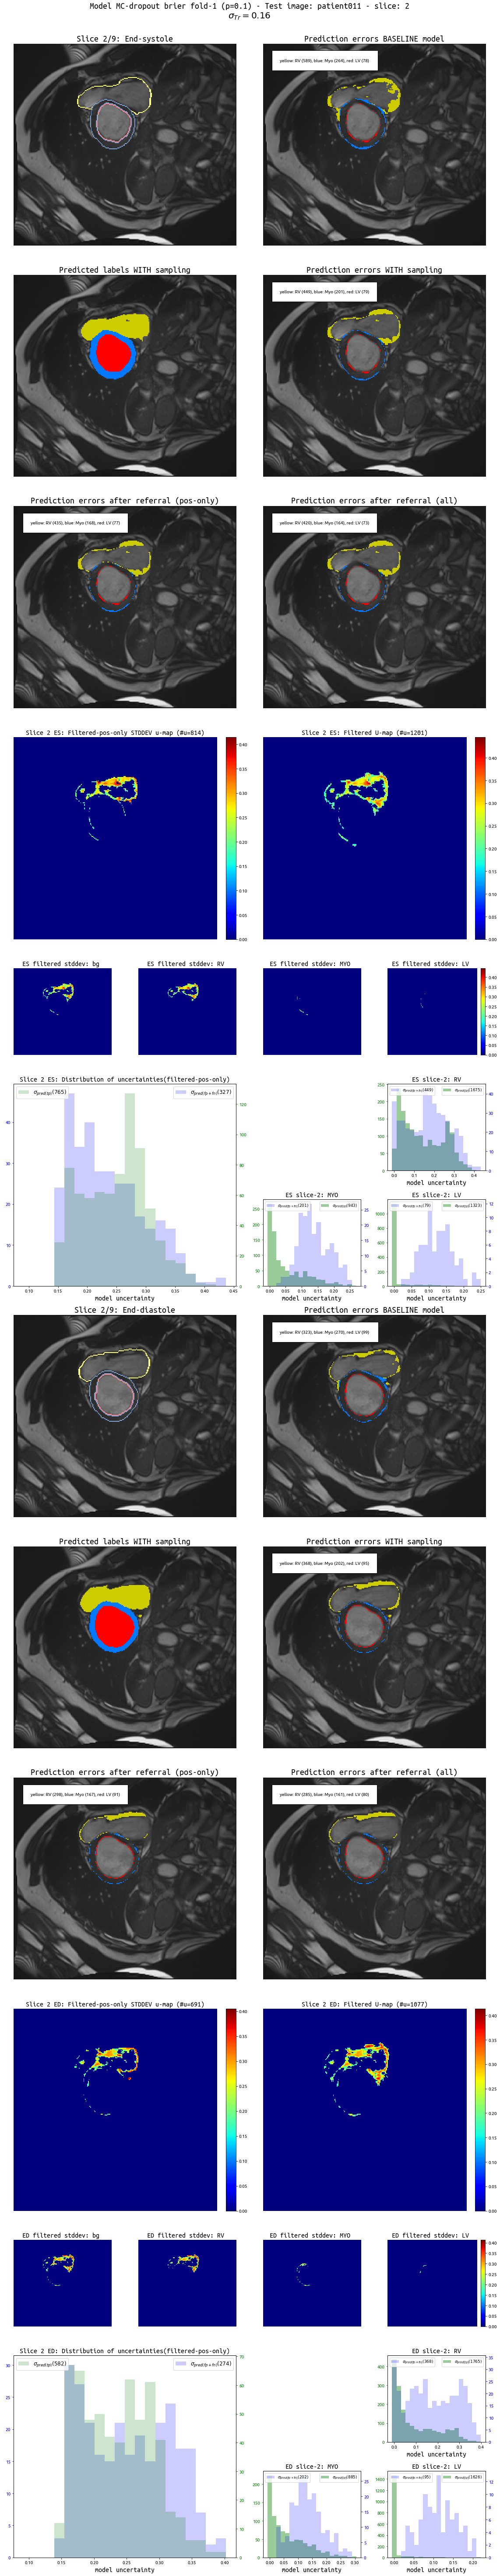

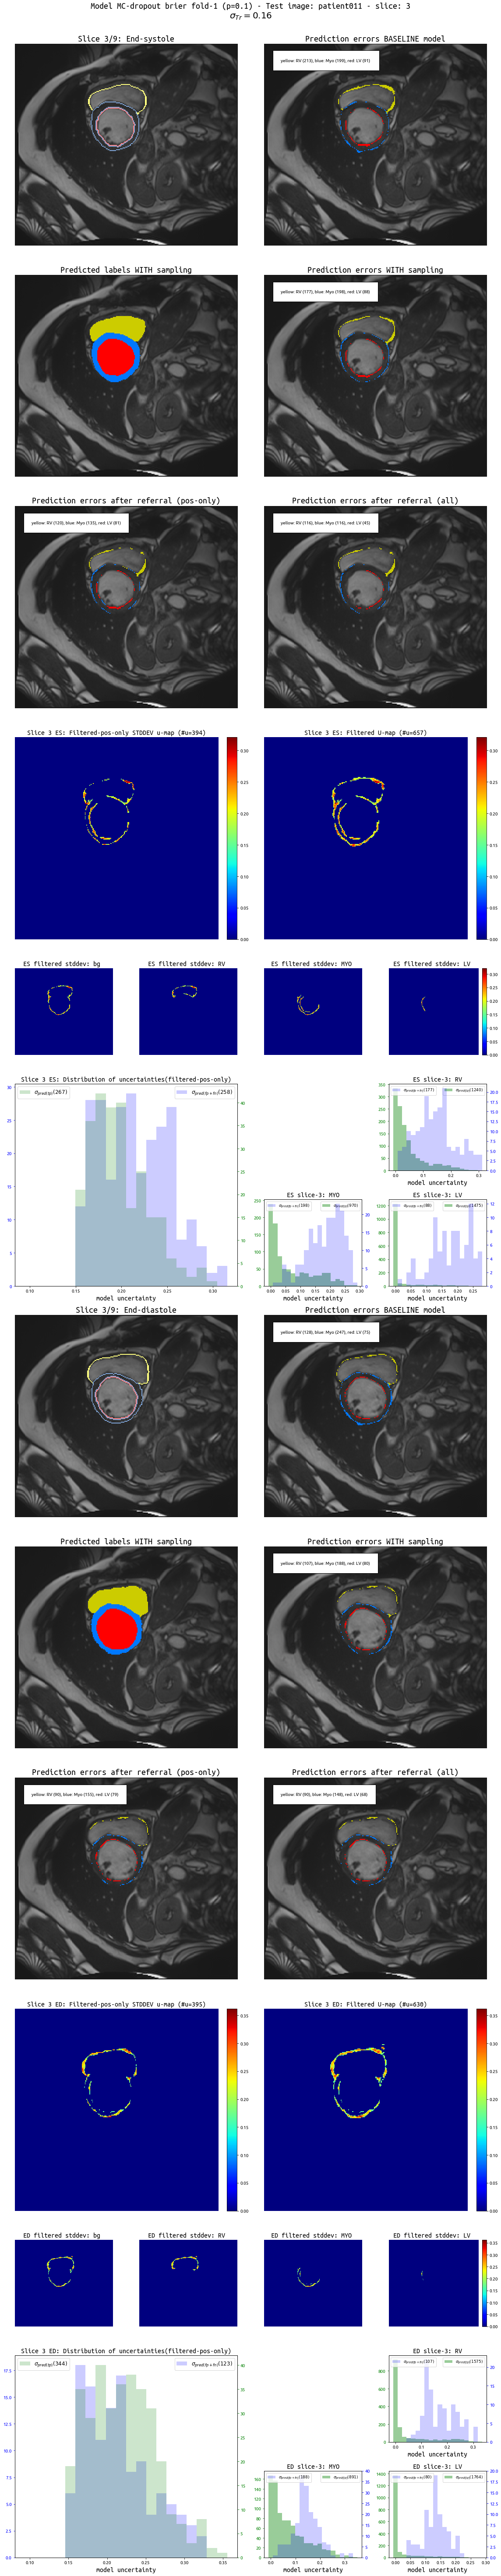

In [5]:
exper_handler = exper_hdl_mc01_brier
model_name = exper_handler.exper.model_name

plot_seg_erros_uncertainties(exper_handler, test_set, patient_id="patient011", 
                             test_results=None, # exper_handler.test_results
                             referral_threshold=0.16, do_show=True, 
                             model_name=model_name, info_type="uncertainty", 
                             do_save=False, slice_range=[1,2], errors_only=False,
                             load_base_model_pred_labels=True)

In [ ]:
# model_name a) Baseline  b) MC-dropout 0.1

model_name = exper_handler.exper.model_name
errors_only = False  # in case of the BASELINE model we only want the seg-errors
plot_detailed_hists = True
image_range = [0]
if image_range is None:
    image_range = np.arange(len(exper_handler.test_results.image_names))


for image_num in image_range:
    exper_handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                                 info_type="uncertainty",
                                                                 do_save=False, slice_range=[0, 1],
                                                                 std_threshold=0.12, errors_only=errors_only, 
                                                                 do_show=True, use_bald=True,
                                                                 model_name = model_name,
                                                                 plot_detailed_hists=plot_detailed_hists,
                                                                 load_referral=True, ref_positives_only=True)
                                                                 # uncertainty
    print("INFO - Ready!")


(8, 291, 321, 11)


(-0.5, 320.5, 290.5, -0.5)

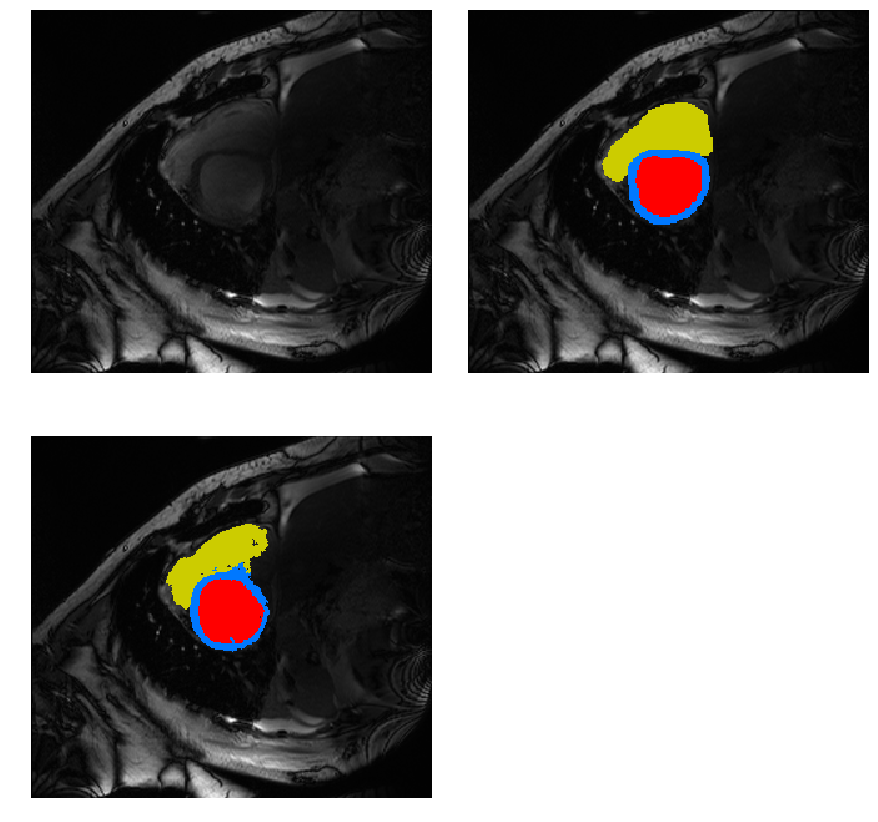

In [27]:
import copy
from common.common import overlay_seg_mask, to_rgb1a


exper_handler = exper_hdl_mc01_brier
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.u_map_dir))
pred_lbl_input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.pred_lbl_dir))
file_name_lbl = os.path.join(pred_lbl_input_dir, "patient006_pred_labels_mc.npz")

file_name_ref_lbl = os.path.join(pred_lbl_input_dir, "patient006_filtered_pred_labels_mc0_18_pos_only.npz")


data_lbl = np.load(file_name_lbl)
pred_labels = data_lbl["pred_labels"]
data_ref_lbl = np.load(file_name_ref_lbl)
print(pred_labels.shape)

org_img = exper_handler.test_results.images[0]
org_ref = exper_handler.test_results.labels[0]
org_img_ed = org_img[1]
org_img_ed_slice3 = org_img_ed[:, :, 2]

rgb_org_img_ed_slice3 = to_rgb1a(org_img_ed_slice3)
saved_rgb_copy = copy.deepcopy(rgb_org_img_ed_slice3)
org_ref_ed_slice3 = org_ref[:, :, :, 2]
pred_ref_ed_slice3 = pred_labels[:, :, :, 2]

img_slice_with_gt_segs = overlay_seg_mask(rgb_org_img_ed_slice3, org_ref_ed_slice3, cls_offset=4)
rgb_org_img_ed_slice3 = copy.deepcopy(saved_rgb_copy)
mg_slice_with_pred_segs = overlay_seg_mask(rgb_org_img_ed_slice3, pred_ref_ed_slice3, cls_offset=4)

fig = plt.figure(figsize=(15, 15))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot.imshow(org_img_ed_slice3, cmap=plt.get_cmap('gray'))
plt.axis("off")
ax4aplot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4aplot = plt.imshow(img_slice_with_gt_segs)
plt.axis("off")
ax4bplot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4bplot = plt.imshow(mg_slice_with_pred_segs)
plt.axis("off")

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice_pos_only, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(ref_pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")

plt.show()

del u_map
del u_map_es
del u_map_slice

In [ ]:
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, config.u_map_dir))
file_name = os.path.join(input_dir, "patient007_filtered_cls_umaps0_14.npz")
data = np.load(file_name)
u_map = data["filtered_cls_umap"]
u_map_es = u_map[:4]
img_slice = 9
u_map_slice = u_map_es[:, :, :, img_slice]
print(u_map_slice.shape)
u_map_slice = np.sum(u_map_slice, axis=0)
print("After max ", u_map_slice.shape)
u_map_max = np.max(u_map_slice)
print("U-map max {:.2f}".format(u_map_max))
print(np.count_nonzero(u_map_slice[u_map_slice >= 0.14]))
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
plt.show()
del u_map
del u_map_es
del u_map_slice

In [ ]:
from skimage import data, segmentation
from skimage import exposure
gb_error_codes = [[], (1, 1, 0.), (0., 0.3, 0.7), (1, 0, 0)]

img_es = exper_handler.test_results.images[0][0, :, :, 0]
mask = np.zeros_like(img_es)
rv_lbls = exper_handler.test_results.labels[0][1, :, :, 0]
mask[rv_lbls == 1] = 1
myo_lbls = exper_handler.test_results.labels[0][2, :, :, 0]
mask[myo_lbls == 1] = 2
lv_lbls = exper_handler.test_results.labels[0][3, :, :, 0]
mask[lv_lbls == 1] = 3
img_es = exposure.rescale_intensity(img_es)
clean_border_rv = segmentation.clear_border(rv_lbls).astype(np.int)
clean_border_myo = segmentation.clear_border(myo_lbls).astype(np.int)
clean_border_lv = segmentation.clear_border(lv_lbls).astype(np.int)
img_lbl = segmentation.mark_boundaries(img_es, clean_border_rv, mode="outer", color=gb_error_codes[1], 
                                       background_label=0)
img_lbl = segmentation.mark_boundaries(img_lbl, clean_border_lv, mode="inner", color=gb_error_codes[3], 
                                       background_label=0)
img_lbl = segmentation.mark_boundaries(img_lbl, clean_border_myo, mode="inner", color=gb_error_codes[2], 
                                       background_label=0)
img_lbl = exposure.rescale_intensity(img_lbl, out_range=(0, 1))

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=2)
ax1.imshow(img_lbl)
plt.axis('off')